<a href="https://colab.research.google.com/github/tleyden/FruitPunch_AI_Bootcamp/blob/main/FruitPunch_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pip installs

In [1]:
!apt install -y jq
!pip install pycocotools
!python -m pip install pyyaml==5.1


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libjq1 libonig4
The following NEW packages will be installed:
  jq libjq1 libonig4
0 upgraded, 3 newly installed, 0 to remove and 20 not upgraded.
Need to get 276 kB of archives.
After this operation, 930 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libonig4 amd64 6.7.0-1 [119 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libjq1 amd64 1.5+dfsg-2 [111 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 jq amd64 1.5+dfsg-2 [45.6 kB]
Fetched 276 kB in 0s (914 kB/s)
Selecting previously unselected package libonig4:amd64.
(Reading database ... 124013 files and directories currently installed.)
Preparing to unpack .../libo

## Imports

In [2]:
import os
from matplotlib import pyplot as plt
import cv2

from pycocotools.coco import COCO
import skimage.io as io
from pathlib import Path

import sys, distutils.core
from google.colab.patches import cv2_imshow


## Authenticate with google drive and mount it

In [3]:
from google.colab import auth
auth.authenticate_user()

In [4]:
# Mount google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Copy annotations from gdrive to local dir

In [5]:
!cp -r "/content/drive/MyDrive/Projects/FruitPunchAI/Toy challenges/Poacher detection/Labeled data/annotations" .

In [6]:
!ls annotations

instances_test.json  instances_train.json  instances_val.json


## Download zips from google bucket

In [15]:
if not os.path.exists("gs://fruitpunch-ai-tleyden/Labeled data-20211126T095740Z-001.zip"):
    !gsutil cp "gs://fruitpunch-ai-tleyden/Labeled data-20211126T095740Z-001.zip" .
if not os.path.exists("gs://fruitpunch-ai-tleyden/Labeled data-20211126T095740Z-002.zip"):
    !gsutil cp "gs://fruitpunch-ai-tleyden/Labeled data-20211126T095740Z-002.zip" .


Copying gs://fruitpunch-ai-tleyden/Labeled data-20211126T095740Z-001.zip...
/ [1 files][  2.0 GiB/  2.0 GiB]   86.7 MiB/s                                   
Operation completed over 1 objects/2.0 GiB.                                      
Copying gs://fruitpunch-ai-tleyden/Labeled data-20211126T095740Z-002.zip...
- [1 files][809.6 MiB/809.6 MiB]   79.3 MiB/s                                   
Operation completed over 1 objects/809.6 MiB.                                    


In [16]:
!unzip "Labeled data-20211126T095740Z-001.zip"
!unzip "Labeled data-20211126T095740Z-002.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Labeled data/images/train/videobh_1_000230.PNG  
  inflating: Labeled data/images/train/video53_9_000162.PNG  
  inflating: Labeled data/images/train/videobh_1_003456.PNG  
  inflating: Labeled data/images/train/videobh_1_002075.PNG  
  inflating: Labeled data/images/train/videobh_2_000593.PNG  
  inflating: Labeled data/images/train/videobh_1_000905.PNG  
  inflating: Labeled data/images/train/videobh_1_003138.PNG  
  inflating: Labeled data/images/train/video53_1_001716.PNG  
  inflating: Labeled data/images/train/video53_1_000897.PNG  
  inflating: Labeled data/images/train/video53_2_002344.PNG  
  inflating: Labeled data/images/train/video78_1_001157.PNG  
  inflating: Labeled data/images/train/video78_1_001110.PNG  
  inflating: Labeled data/images/train/video53_9_000330.PNG  
  inflating: Labeled data/images/train/videobh_1_002617.PNG  
  inflating: Labeled data/images/train/videobh_3_000573.PNG  
  inflating: Labele

## Re-arrange directories to match expected structure

In [17]:
!mv "Labeled data" labeled_data

In [18]:
!mkdir labeled_data/images/test 
!mv labeled_data/images/*.PNG labeled_data/images/test 

## Set path variables

In [19]:
DATA_PATH = '/content/labeled_data/'
IMAGES_PATH = DATA_PATH + 'images/'
LABELS_PATH = DATA_PATH + 'annotations/'

# Get paths to IMAGE directories
TRAIN_IMAGES_PATH = IMAGES_PATH + 'train/'
TEST_IMAGES_PATH = IMAGES_PATH + 'test/'
VAL_IMAGES_PATH = IMAGES_PATH + 'val/'

TRAIN_LABELS = LABELS_PATH + 'instances_train.json'
TEST_LABELS = LABELS_PATH + 'instances_test_dataset.json'
VAL_LABELS = LABELS_PATH + 'instances_val.json'

## Step 1 - analyze the data

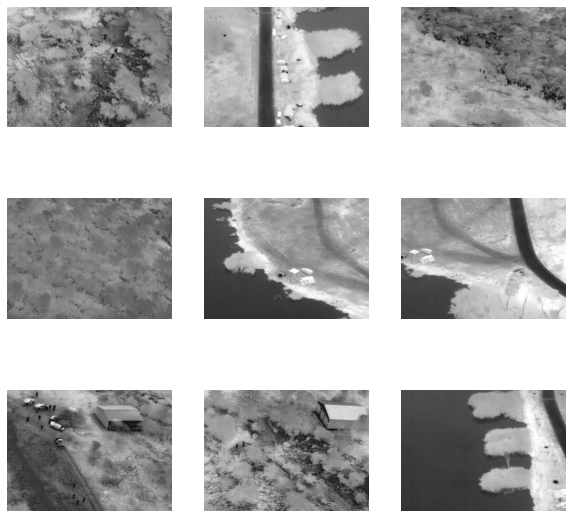

In [20]:
# View some train images
plt.figure(figsize=(10, 10))
TRAIN_IMAGES = os.listdir(TRAIN_IMAGES_PATH)
for i in range(9):
  img_path = TRAIN_IMAGES_PATH + TRAIN_IMAGES[i]
  ax = plt.subplot(3, 3, i + 1)
  img = cv2.imread(img_path, )
  plt.imshow(img, cmap='gray')
  plt.axis("off")

In [21]:
# Analyse training annotations
coco = COCO(TRAIN_LABELS) # return dictionary of the dataset
img_IDs = coco.getImgIds() # get image IDs
imgs = coco.loadImgs(img_IDs[1100:1103]) # load images

loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


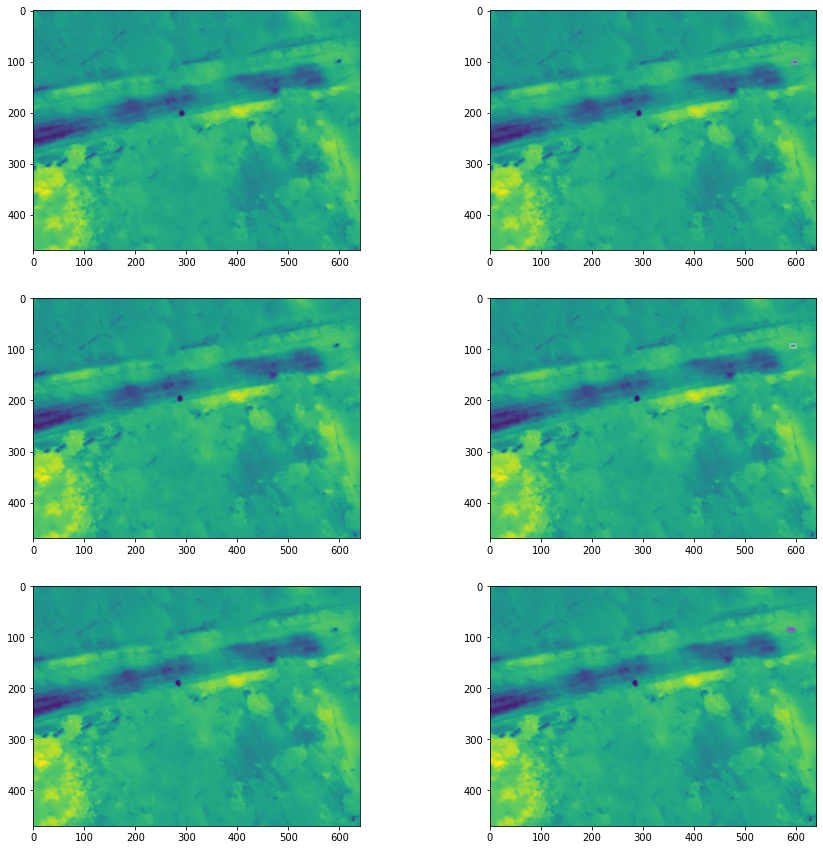

In [22]:

# Visualise images and annotations
_, axs = plt.subplots(len(imgs), 2, figsize=(15, 15))
for img, ax in zip(imgs, axs):
    I = io.imread(Path(TRAIN_IMAGES_PATH)/img['file_name'])
    annIds = coco.getAnnIds(imgIds=[img['id']])
    anns = coco.loadAnns(annIds)
    ax[0].imshow(I)
    ax[1].imshow(I)
    plt.sca(ax[1])
    coco.showAnns(anns, draw_bbox=True)

## Step 2 - model

### Install detectron2

In [23]:
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

Cloning into 'detectron2'...
remote: Enumerating objects: 14641, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 14641 (delta 19), reused 36 (delta 10), pack-reused 14584
Receiving objects: 100% (14641/14641), 6.00 MiB | 22.34 MiB/s, done.
Resolving deltas: 100% (10577/10577), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 3.1 MB/s 
     |████████████████████████████████| 79 kB 7.5 MB/s 
     |████████████████████████████████| 153 kB 37.3 MB/s 
     |████████████████████████████████| 1.5 MB 67.4 MB/s 
     |████████████████████████████████| 549 kB 70.3 MB/s 
     |████████████████████████████████| 117 kB 82.3 MB/s 
     |████████████████████████████████| 96 kB 7.3 MB/s 
     |████████████████████████████████| 182 kB 78.2 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221122-py3-none-any.whl size=61484 s

### Show versions

In [24]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
torch:  1.13 ; cuda:  cu116
detectron2: 0.6


### Import modules

In [25]:
# import detectron2 modules
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

import json, random
from detectron2.data.datasets import register_coco_instances


### Register coco instances

In [26]:
register_coco_instances("my_dataset_train", {}, TRAIN_LABELS, TRAIN_IMAGES_PATH)
register_coco_instances("my_dataset_test", {}, TEST_LABELS, TEST_IMAGES_PATH)
register_coco_instances("my_dataset_val", {}, VAL_LABELS, VAL_IMAGES_PATH)

### Get dictionary of filenames and image ids

In [27]:

# get dictionary of filename and image ids
def get_filenames(filename_dict, json_file):
    with open(json_file) as f:
      imgs_anns = json.load(f)
    for idx in imgs_anns["images"]:
      filename = idx["file_name"]
      img_id = idx["id"]
      filename_dict[img_id] = filename
    return filename_dict

filename_dict = {}
get_filenames(filename_dict, TRAIN_LABELS)
get_filenames(filename_dict, TEST_LABELS)
get_filenames(filename_dict, VAL_LABELS)

{124: 'video53_1_000123.PNG',
 125: 'video53_1_000124.PNG',
 126: 'video53_1_000125.PNG',
 127: 'video53_1_000126.PNG',
 128: 'video53_1_000127.PNG',
 129: 'video53_1_000128.PNG',
 131: 'video53_1_000130.PNG',
 133: 'video53_1_000132.PNG',
 134: 'video53_1_000133.PNG',
 135: 'video53_1_000134.PNG',
 136: 'video53_1_000135.PNG',
 137: 'video53_1_000136.PNG',
 138: 'video53_1_000137.PNG',
 139: 'video53_1_000138.PNG',
 140: 'video53_1_000139.PNG',
 141: 'video53_1_000140.PNG',
 142: 'video53_1_000141.PNG',
 143: 'video53_1_000142.PNG',
 144: 'video53_1_000143.PNG',
 145: 'video53_1_000144.PNG',
 147: 'video53_1_000146.PNG',
 148: 'video53_1_000147.PNG',
 149: 'video53_1_000148.PNG',
 150: 'video53_1_000149.PNG',
 151: 'video53_1_000150.PNG',
 152: 'video53_1_000151.PNG',
 154: 'video53_1_000153.PNG',
 155: 'video53_1_000154.PNG',
 156: 'video53_1_000155.PNG',
 157: 'video53_1_000156.PNG',
 158: 'video53_1_000157.PNG',
 159: 'video53_1_000158.PNG',
 160: 'video53_1_000159.PNG',
 161: 'vid

### Visualize training data

[12/13 00:19:48 d2.data.datasets.coco]: Loaded 13111 images in COCO format from /content/labeled_data/annotations/instances_train.json


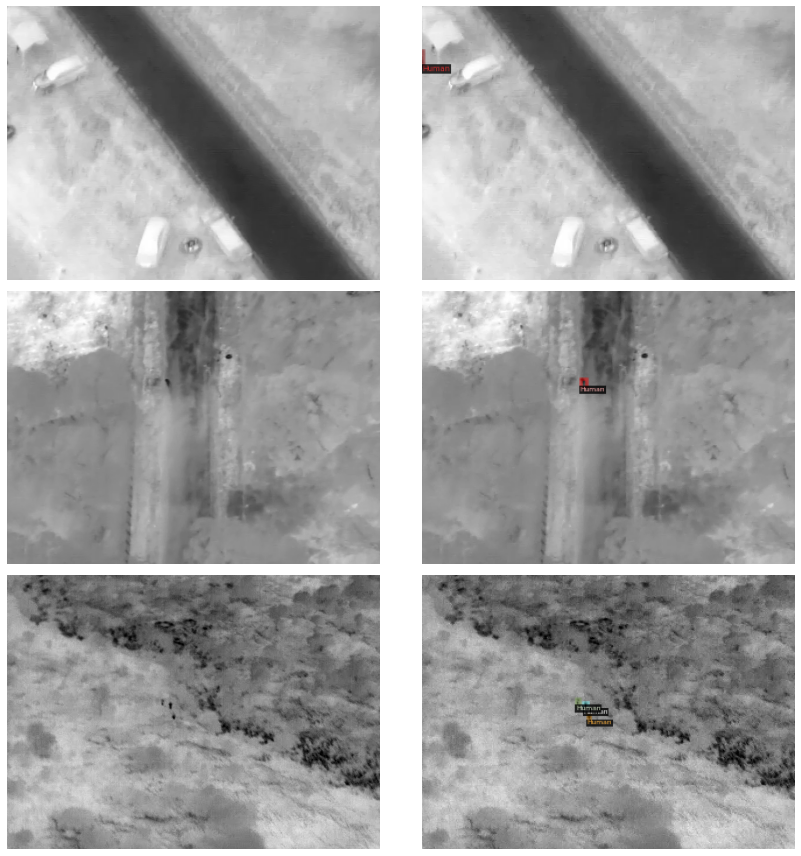

In [28]:

# visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

_, axs = plt.subplots(len(imgs), 2, figsize=(12, 12))
for d, ax in zip(random.sample(dataset_dicts, 3), axs):
    id = d["image_id"]
    filename = filename_dict[id]
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    # cv2_imshow(vis.get_image()[:, :, ::-1])
    ax[0].imshow(img); ax[0].axis('off')
    ax[1].imshow(vis.get_image()[:, :, ::-1]); ax[1].axis('off')
    plt.tight_layout()

## Training

fine-tune a COCO-pretrained model on the custom dataset


### Create config

In [29]:
from detectron2.engine import DefaultTrainer

pretrained_model = "faster_rcnn_R_50_FPN_1x.yaml"

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(f"COCO-Detection/{pretrained_model}"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(f"COCO-Detection/{pretrained_model}")  # Let training initialize from model zoo

# SOLVER.IMS_PER_BATCH is what's commonly known as batch size in deep learning and refers to the number of training examples utilized in one iteration.
# REF: https://stackoverflow.com/questions/72637875/detectron2-difference-between-solver-ims-per-batch-and-model-roi-heads-batch-siz
cfg.SOLVER.IMS_PER_BATCH = 4

cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 2000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05

# MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE is a parameter that is used to sample a subset of proposals coming out of RPN to calculate cls and reg loss during training.
# REF: https://stackoverflow.com/questions/72637875/detectron2-difference-between-solver-ims-per-batch-and-model-roi-heads-batch-siz
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 16

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

cfg.TEST.EVAL_PERIOD = 500

### Define cocotrainer

In [30]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

### Run training

In [ ]:

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[12/13 00:19:58 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
model_final_b275ba.pkl: 167MB [00:03, 49.9MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[12/13 00:20:11 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/13 00:20:37 d2.utils.events]:  eta: 0:25:35  iter: 19  total_loss: 1.754  loss_cls: 0.7101  loss_box_reg: 0.7408  loss_rpn_cls: 0.1633  loss_rpn_loc: 0.07149  time: 0.7887  data_time: 0.0584  lr: 1.931e-06  max_mem: 4211M
[12/13 00:20:53 d2.utils.events]:  eta: 0:26:05  iter: 39  total_loss: 1.651  loss_cls: 0.7036  loss_box_reg: 0.6883  loss_rpn_cls: 0.1441  loss_rpn_loc: 0.04981  time: 0.7919  data_time: 0.0249  lr: 2.911e-06  max_mem: 4211M
[12/13 00:21:09 d2.utils.events]:  eta: 0:25:52  iter: 59  total_loss: 1.646  loss_cls: 0.6794  loss_box_reg: 0.701  loss_rpn_cls: 0.09033  loss_rpn_loc: 0.04894  time: 0.7930  data_time: 0.0224  lr: 3.891e-06  max_mem: 4211M
[12/13 00:21:25 d2.utils.events]:  eta: 0:26:22  iter: 79  total_loss: 1.549  loss_cls: 0.6451  loss_box_reg: 0.737  loss_rpn_cls: 0.1008  loss_rpn_loc: 0.04752  time: 0.8029  data_time: 0.0215  lr: 4.871e-06  max_mem: 4211M
[12/13 00:21:42 d2.utils.events]:  eta: 0:26:14  iter: 99  total_loss: 1.583  loss_cls: 0.6087  l